# Clean Data

In [1]:
import pandas as pd
import numpy as np
import helper
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
# pd.read_csv("International_games/results.csv", index_col='date', parse_dates=True).head(3)

# Clean FIFA players data

In [4]:
def get_clean_fifa_ratings(year):
    # Read CSV file of a specific year, clean the data and store it in a DataFrame
    data_fifa_players = pd.read_csv(f"Fifa_players/FIFA{year}_official_data.csv")
    data_fifa_players = data_fifa_players.set_index('ID')
    data_fifa_players = data_fifa_players[data_fifa_players["Overall"] >= 55]

    # Clean players' position
    data_fifa_players["Position"] = data_fifa_players["Position"].str.extract(r">(\w+)")
    if "Best Position" in data_fifa_players.columns:
        data_fifa_players['Position'] = data_fifa_players['Best Position'].fillna(value=data_fifa_players['Position'])
    
    # Keep only desired columns
    data_fifa_players = data_fifa_players[['Name', 'Nationality', 'Overall', 'Position', 'Club']]
    data_fifa_players['Club'] = data_fifa_players['Club'].transform(lambda x: "NONE" if pd.isna(x) else x.upper())
    data_fifa_players["Year"] = [year]*len(data_fifa_players)
    
    
    # Remove old players that have a name starting with a number (e.g. "14 D. Beckam")
    data_fifa_players['Name'] = data_fifa_players['Name'].transform(lambda x: np.NaN if (x.lstrip(" ")[0] == "0" or x.lstrip(" ")[0] == "1" or x.lstrip(" ")[0] == "2") else x)
    data_fifa_players = data_fifa_players.dropna()
    
    # We could improve the Overall (rating) with the potential of the player, the age, etc...

    return data_fifa_players

def clean_position(x, data_previous_year):
    # Function applied to a dataframe in the function "get_all_fifa_ratings"
    # Tries to reduce the number of players that have a postion names:
    # SUB for substitute or RES for reserviste (in which case we don't know there
    # position on the field!)
    if x["Position"] not in ["RES", "SUB"]:
        return x
    else:
        try:
            x["Position"] = data_previous_year.loc[x.name]["Position"]
        except KeyError:
            pass
    return x

def get_all_fifa_ratings():
    # Put all the data together (for each of the years) and clean the players' position
    data_all = pd.DataFrame()
    for year in range(17, 24):
        data_year = get_clean_fifa_ratings(year)
        if year >= 18:
            data_year = data_year.apply(clean_position, args=[data_all[data_all["Year"] == (year-1)]], axis=1)
        data_all = pd.concat([data_all, data_year])
    return data_all


In [5]:
data_fifa_players_raw = pd.read_csv(f"Fifa_players/FIFA23_official_data.csv")

In [7]:
data_players_22 = get_clean_fifa_ratings(23)

In [8]:
data_all_players = get_all_fifa_ratings()

In [10]:
# TEST: Check which teams aren't in the fifa database (their names have
# to be matched with those in fifa)
# def manual_cleaning_names(data_games):

# list_teams_to_replace = []
# for team in data_games["home_team"].unique():
#     if team not in list(data_all_players["Nationality"]):
#         print(f"Name games : {team}")
#         list_teams_to_replace.append(team)
# print(list_teams_to_replace)

# Clean games data

In [11]:
def match_club_names(x):
    # to be applied to a DataFrame
    # Changes the names of the club to match those in fifa
    if x["home_team"] in helper.DICT_TO_CLUB_NAME_DATA_TO_FIFA.keys():
        x["home_team"] = helper.DICT_TO_CLUB_NAME_DATA_TO_FIFA[x["home_team"]]
    if x["away_team"] in helper.DICT_TO_CLUB_NAME_DATA_TO_FIFA.keys():
        x["away_team"] = helper.DICT_TO_CLUB_NAME_DATA_TO_FIFA[x["away_team"]]
    return x

def get_clean_games():
    data_games = pd.read_csv("International_games/results.csv", index_col='date', parse_dates=True)
    data_games = data_games[['home_team', 'away_team', 'home_score', 'away_score',
        'tournament']].loc["2016":]
    data_games = data_games.reset_index()
    data_games['Year'] = data_games['date'].transform(lambda x: int(x.year) - 2000 if x.month < 8 else int(x.year) + 1 - 2000)
    data_games = data_games.set_index('date')
    data_games = data_games[data_games['Year'] > 16]
    
    # print(data_games['tournament'].unique())
    data_games = data_games[
        (data_games['tournament'] == "FIFA World Cup") +
        (data_games['tournament'] == "Copa América") +
        (data_games['tournament'] == "UEFA Euro") +
        (data_games['tournament'] == "Gold Cup") +
        (data_games['tournament'] == "AFC Asian Cup") +
        (data_games['tournament'] == "African Cup of Nations")        
    ]
    data_games = data_games.apply(match_club_names, axis=1)

    data_games["home_team_year"] = data_games["home_team"] + "_" + data_games["Year"].astype(str)
    data_games["away_team_year"] = data_games["away_team"] + "_" + data_games["Year"].astype(str)
    
    return data_games

In [12]:
data_games = get_clean_games()

# Make teams

In [13]:
def get_potential_players(players_country, list_fifa_positions):
    potential_players = pd.DataFrame(columns=["ID", "Name", "Overall"])
    for fifa_position in list_fifa_positions:
        players_country_and_position = players_country[players_country["Position"] == fifa_position].sort_values("Overall", ascending=False)
        if len(players_country_and_position) != 0:
            potential_players = pd.concat(
                [
                    potential_players,
                    pd.DataFrame({
                        "ID": [players_country_and_position.iloc[0].name], 
                        "Name": [players_country_and_position.iloc[0]["Name"]],
                        "Overall": [players_country_and_position.iloc[0]["Overall"]]
                    })
                ],
                axis=0)
    return potential_players
    

def get_players_team(team, data_players, year, version, display=False):
    # version: "Club" or "Nationality"
    players_country = data_players[
        (data_players[version] == team) &
        (data_players["Year"] == year)]
    dict_positions = {
        "ST1":["ST", "CF", "LS", "RS"],
        "ST2":["ST", "CF", "LF", "RF", "LS", "RS", "RW", "LW"],
        "CM1":["CM", "LCM", "RCM", "CAM", "RAM", "LAM"],
        "CM2":["CM", "LCM", "RCM", "CDM", "RDM", "LDM"],
        "LM": ["LW", "LM", 'LAM', 'CAM'],
        "RM": ["RM", "RW", "RAM", 'CAM'],
        "CB1":["CB", "LCB", "RCB"],
        "CB2":["CB", "LCB", "RCB"],
        "LB": ["LWB", "LB", "CB", "LCB"],
        "RB": ["RWB", "RB", "CB", "RCB"],
        "GK": ["GK"]
        }
    
    list_overall_players_in_team = []
    for defined_position, list_fifa_positions in dict_positions.items():
        potential_players = get_potential_players(players_country, list_fifa_positions)
            # print(players_country_and_position.iloc[0])
            # print(potential_players)
        if len(potential_players) == 0:
            list_fifa_positions = ["SUB", "RES"]
            potential_players = get_potential_players(players_country, list_fifa_positions)
        if len(potential_players) == 0:
            potential_players = pd.DataFrame({
                "ID": [0], 
                "Name": ["Average"],
                "Overall": [int(np.mean(list_overall_players_in_team)*0.95)]
            })
        else:
            potential_players = potential_players.sort_values("Overall", ascending=False)
            players_country = players_country.drop(potential_players.iloc[0].ID, axis=0)
        list_overall_players_in_team.append(potential_players.iloc[0]["Overall"])
        if display:
            print(f"{defined_position}: - {list_fifa_positions} - {potential_players.iloc[0]['Name']} - {potential_players.iloc[0]['Overall']}")

    players_in_team = pd.DataFrame(columns=["Year", "Team"]+list(dict_positions.keys()))
    players_in_team.loc[len(players_in_team)] = [year, team] + list_overall_players_in_team
        
    return players_in_team


In [14]:
def get_roster(data_games, data_all_players, version):
    # get the roster of every team in the games data
    data_rosters = pd.DataFrame()
    teams_not_found = []
    for year in data_all_players["Year"].unique():
        for team in (pd.concat([data_games[data_games["Year"] == year]["home_team"], data_games[data_games["Year"] == year]["away_team"]])).unique():
            try:
                data_rosters = pd.concat([data_rosters, get_players_team(team, data_all_players, year=year, version=version)], axis=0)
            except ValueError:
                teams_not_found.append(f"{year}_{team}")
                print(year, team)
    data_rosters["Team_year"] = data_rosters["Team"] + "_" + data_rosters["Year"].astype(str)
    # print(teams_not_found)
    return data_rosters

In [15]:
get_players_team("England", data_all_players, year=23, display=True, version="Nationality")

ST1: - ['ST', 'CF', 'LS', 'RS'] - H. Kane - 89
ST2: - ['ST', 'CF', 'LF', 'RF', 'LS', 'RS', 'RW', 'LW'] - R. Sterling - 86
CM1: - ['CM', 'LCM', 'RCM', 'CAM', 'RAM', 'LAM'] - R. Kent - 83
CM2: - ['CM', 'LCM', 'RCM', 'CDM', 'RDM', 'LDM'] - J. Bellingham - 84
LM: - ['LW', 'LM', 'LAM', 'CAM'] - J. Grealish - 84
RM: - ['RM', 'RW', 'RAM', 'CAM'] - P. Foden - 85
CB1: - ['CB', 'LCB', 'RCB'] - F. Tomori - 84
CB2: - ['CB', 'LCB', 'RCB'] - J. Stones - 83
LB: - ['LWB', 'LB', 'CB', 'LCB'] - B. Chilwell - 82
RB: - ['RWB', 'RB', 'CB', 'RCB'] - T. Alexander-Arnold - 87
GK: - ['GK'] - J. Pickford - 82


,Year,Team,ST1,ST2,CM1,CM2,LM,RM,CB1,CB2,LB,RB,GK
0,23,England,89,86,83,84,84,85,84,83,82,87,82


In [16]:
data_rosters = get_roster(data_games, data_all_players, version="Nationality")

/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 Guinea-Bissau


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 French Guiana


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 Martinique


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 Curaçao


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 El Salvador


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 Nicaragua


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 United Arab Emirates


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Iraq


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Qatar


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Bahrain
19 Jordan


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_

19 Philippines
19 Kyrgyzstan
19 Vietnam
19 Yemen
19 Lebanon
19 North Korea


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Oman
19 Turkmenistan


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Curaçao


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Cuba
19 Nicaragua


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Guyana


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Martinique


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Uganda
19 Trinidad and Tobago


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Mauritania


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Namibia


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 Guinea-Bissau


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


21 El Salvador


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


21 Qatar


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


21 Trinidad and Tobago
21 Guatemala


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_

21 Guadeloupe
21 Suriname
21 Grenada


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


21 Martinique


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 Ethiopia


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 Comoros


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 Equatorial Guinea


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 Cape Verde
22 Malawi


/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thibaud/miniconda3/envs/sdse/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 Guinea-Bissau
22 Ivory Coast


In [17]:
data_rosters

,Year,Team,ST1,ST2,CM1,CM2,LM,RM,CB1,CB2,LB,RB,GK,Team_year
0,17,Burkina Faso,68,74,78,77,74,71,75,71,70,68,68,Burkina Faso_17
0,17,Gabon,87,67,77,74,68,70,72,70,69,69,70,Gabon_17
0,17,Algeria,82,75,82,79,80,84,77,74,79,74,67,Algeria_17
0,17,Tunisia,73,73,79,73,74,73,78,75,72,72,55,Tunisia_17
0,17,DR Congo,81,78,76,73,77,78,76,73,71,72,68,DR Congo_17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,23,Australia,75,70,76,71,75,72,72,72,70,72,78,Australia_23
0,23,Costa Rica,66,71,61,58,65,71,67,62,62,74,88,Costa Rica_23
0,23,Canada,74,72,74,76,70,79,69,67,84,67,77,Canada_23
0,23,Serbia,84,84,86,79,85,77,80,74,74,74,80,Serbia_23


# Create final dataframe

In [18]:
data_full = pd.merge(left=data_games, right=data_rosters, how='inner', left_on="home_team_year", right_on="Team_year")
data_full = pd.merge(left=data_full, right=data_rosters, how='inner', left_on="away_team_year", right_on="Team_year")
data_full.drop(["Year_x", "tournament", "Year_y", "home_team", "away_team", "home_team_year", "away_team_year", "Team_year_x", "Team_year_y", "Team_x", "Team_y", "Year"], axis=1, inplace=True)
data_full = data_full.dropna()

In [64]:
def get_result(x):
    if x["home_score"] > x["away_score"]:
        return "w_home"
    elif x["home_score"] < x["away_score"]:
        return "w_away"
    return "draw"

In [20]:
data_full["Result"] = data_full.apply(get_result, axis=1)
data_full.drop(["home_score", "away_score"], axis=1, inplace=True)
data_full

,ST1_x,ST2_x,CM1_x,CM2_x,LM_x,RM_x,CB1_x,CB2_x,LB_x,RB_x,GK_x,ST1_y,ST2_y,CM1_y,CM2_y,LM_y,RM_y,CB1_y,CB2_y,LB_y,RB_y,GK_y,Result
0,68,74,78,77,74,71,75,71,70,68,68,81,78,75,77,73,73,83,78,78,77,81,draw
1,87,67,77,74,68,70,72,70,69,69,70,81,78,75,77,73,73,83,78,78,77,81,draw
2,79,79,77,82,74,82,83,78,78,78,73,81,78,75,77,73,73,83,78,78,77,81,draw
3,75,82,73,77,71,74,73,70,72,69,74,81,78,75,77,73,73,83,78,78,77,81,w_away
4,68,74,78,77,74,71,75,71,70,68,68,73,73,79,73,74,73,78,75,72,72,55,w_home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,75,89,73,72,77,72,79,75,72,72,73,76,75,84,76,76,75,78,77,77,72,74,w_away
346,90,85,88,86,84,82,88,81,88,83,82,84,82,84,81,76,78,83,82,78,83,79,w_home
348,81,75,76,71,76,77,79,73,73,75,75,89,86,83,84,84,85,84,83,82,87,82,w_away
349,91,79,83,78,74,74,76,75,73,79,86,86,91,84,81,84,84,83,81,85,79,84,w_away


# Train algorithm (classification)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(data_full.drop("Result", axis=1), data_full["Result"], test_size=0.2)

In [23]:
# We can change the multi_class
model = LogisticRegression(multi_class="multinomial", max_iter=5000)
model.fit(X_train, Y_train)
model.score(X_train, Y_train), model.score(X_test, Y_test)

(0.6101083032490975, 0.5285714285714286)

In [24]:
from lazypredict.Supervised import LazyClassifier

In [25]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, Y_train, Y_test)
models.sort_values("Accuracy", ascending=False)

100%|██████████| 29/29 [00:04<00:00,  6.62it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.67,0.55,None,0.60,0.06
GaussianNB,0.63,0.58,None,0.63,0.03
NearestCentroid,0.60,0.53,None,0.61,0.03
CalibratedClassifierCV,0.60,0.51,None,0.56,0.97
KNeighborsClassifier,0.59,0.55,None,0.60,0.22
RandomForestClassifier,0.59,0.54,None,0.60,0.54
BernoulliNB,0.59,0.51,None,0.59,0.04
ExtraTreesClassifier,0.57,0.52,None,0.58,0.58
RidgeClassifierCV,0.57,0.50,None,0.56,0.04


In [26]:
# How to use LazyPredict
# 
#from lazypredict.Supervised import LazyClassifier
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# data = load_breast_cancer()
# X = data.data
# y= data.target
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

# 2023's World cup prediction (Classification)

In [28]:
def predict_game(team_home, team_away, year, model, version="Classification", display=False):
    if display:
        x = pd.merge(get_players_team(team_home, data_all_players, year=year, display=display, version="Nationality"), get_players_team(team_away, data_all_players, year=year, display=display, version="Nationality"), on="Year")
        x = x.drop(["Year", "Team_x", "Team_y"], axis=1)
    else:
        x = pd.merge(data_rosters[data_rosters["Team_year"] == f"{team_home}_{year}"], data_rosters[data_rosters["Team_year"] == f"{team_away}_{year}"], on="Year")
        x = x.drop(["Year", "Team_x", "Team_y", "Team_year_x", "Team_year_y"], axis=1)

    if display:
        print(['draw', 'w_away', 'w_home'])

    
    if version == "Regression":
        pred = model.predict(x).clip(0, np.infty)[0]
        home_goals = np.random.poisson(lam=pred[0], size=1000)
        away_goals = np.random.poisson(lam=pred[1], size=1000)
        proba_predictions = (home_goals == away_goals).mean(), (home_goals < away_goals).mean(), (home_goals > away_goals).mean()
        result = ['draw', 'w_away', 'w_home'][np.argmax(proba_predictions)]
        if display:
            proba_predictions
        return result, proba_predictions
    
    else:
        if display:
            print(model.predict_proba(x)[0])
        return model.predict(x), model.predict_proba(x)[0]

In [29]:
dict_groups = {
    "A": ["Netherlands", "Senegal", "Ecuador", "Qatar"],
    "B": ["England", "Iran", "United States", "Wales"],
    "C": ["Argentina", "Saudi Arabia", "Mexico", "Poland"],
    "D": ["France", "Australia", "Tunisia", "Denmark"],
    "E": ["Spain", "Costa Rica", "Germany", "Japan"],
    "F": ["Belgium", "Canada", "Morocco", "Croatia"],
    "G": ["Switzerland", "Cameroon", "Brazil", "Serbia"],
    "H": ["Uruguay", "Korea Republic", "Portugal", "Ghana"]
    }
dict_knockouts ={
    "M1": ["A1", "B2"],
    "M2": ["C1", "D2"],
    "M3": ["E1", "F2"],
    "M4": ["G1", "H2"],
    "M5": ["B1", "A2"],
    "M6": ["D1", "C2"],
    "M7": ["F1", "E2"],
    "M8": ["H1", "G2"],
    "QF1": ["M1", "M2"],
    "QF2": ["M3", "M4"],
    "QF3": ["M5", "M6"],
    "QF4": ["M7", "M8"],
    "SF1": ["QF1", "QF2"],
    "SF2": ["QF3", "QF4"],
    "F": ["SF1", "SF2"],
}

In [30]:
def predict_group(group_number, dict_groups, model, version="Classification"):
    group = dict_groups[group_number]
    nb_teams_in_group = len(group)

    group_result = pd.DataFrame({"points":[0]*nb_teams_in_group, "proba":[0.0]*nb_teams_in_group}, index=group)
    for team_home_id in range(nb_teams_in_group):
        for team_away_id in range(team_home_id+1, nb_teams_in_group):
            result = predict_game(group[team_home_id], group[team_away_id], 23, model, version=version)
            # print(f"{group[team_home_id]} {group[team_away_id]} - {result}")
            group_result.loc[group[team_home_id], "proba"] += result[1][2]
            group_result.loc[group[team_away_id], "proba"] += result[1][1]
            if result[0] == "w_home":
                group_result.loc[group[team_home_id], "points"] += 3
            elif result[0] == "w_away":
                group_result.loc[group[team_away_id], "points"] += 3
            else:
                group_result.loc[group[team_home_id], "points"] += 1
                group_result.loc[group[team_away_id], "points"] += 1
    return group_result.sort_values(["points", "proba"], ascending=False)

In [31]:
def predict_cup(dict_groups, dict_knockouts, model, version="Classification", display=True):
    all_results = {}
    for group_number, group in dict_groups.items():
        result = predict_group(group_number, dict_groups, model, version=version)
        all_results[f"{group_number}1"] = result.iloc[0].name
        all_results[f"{group_number}2"] = result.iloc[1].name
        if display:
            print(result)

    for game, teams_playing in dict_knockouts.items():
        if display:
            print(game, end= ": ")
            print(all_results[teams_playing[0]]," vs ", all_results[teams_playing[1]], end=": ")
        result = predict_game(all_results[teams_playing[0]], all_results[teams_playing[1]], 23, model, version=version)
        if result[1][2] > result[1][1]:
            all_results[game] = all_results[teams_playing[0]]
            if display:
                print("home win")
        else:
            all_results[game] = all_results[teams_playing[1]]
            if display:
                print("away win")
    
    return all_results

In [55]:
def stats_on_many_models(nb_iterations, data_full, dict_groups, dict_knockouts, version):
    # version = "Classification" or "Regression"
    stats = {}
    for i in range(nb_iterations):
        if version == "Classification":
            X_train, X_test, Y_train, Y_test = train_test_split(data_full.drop("Result", axis=1), data_full["Result"], test_size=0.2)
            model = LogisticRegression(multi_class="multinomial", max_iter=5000)
        elif version == "Regression":
            X_train, X_test, Y_train, Y_test = train_test_split(data_full.drop(['home_score', 'away_score'], axis=1), data_full[['home_score', 'away_score']], test_size=0.2)
            model = Ridge(alpha=1)
        model.fit(X_train, Y_train)
        winner = predict_cup(dict_groups, dict_knockouts, model, version=version, display=False)["F"]
        if winner in list(stats.keys()):
            stats[winner] += 1/nb_iterations
        else:
            stats[winner] = 1/nb_iterations
    return dict(sorted(stats.items(), key=lambda item: item[1]))

In [33]:
stats = stats_on_many_models(200, data_full, dict_groups, dict_knockouts, version="Classification")

Text(0, 0.5, 'Probability of winning the World Cup')

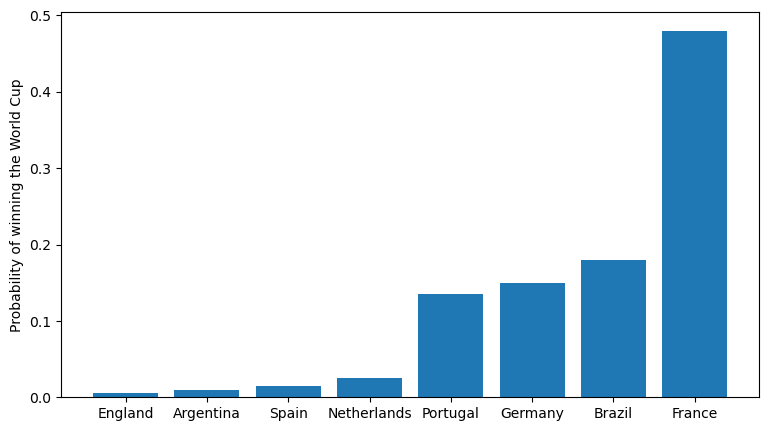

In [51]:
plt.figure(figsize=(9,5))
plt.bar(stats.keys(), stats.values())
plt.ylabel("Probability of winning the World Cup")

In [35]:
predict_cup(dict_groups, dict_knockouts, model)

             points  proba
Netherlands       7   1.64
Senegal           7   1.07
Qatar             1   0.66
Ecuador           1   0.44
               points  proba
England             9   2.22
Wales               6   1.41
United States       3   1.26
Iran                0   0.17
              points  proba
Argentina          7   1.82
Mexico             7   1.13
Saudi Arabia       3   0.85
Poland             0   0.68
           points  proba
France          9   2.02
Denmark         4   0.74
Australia       3   1.03
Tunisia         1   0.49
            points  proba
Germany          7   1.80
Spain            7   1.36
Japan            3   1.01
Costa Rica       0   0.49
         points  proba
Belgium       9   1.37
Morocco       6   1.91
Croatia       3   1.35
Canada        0   0.13
             points  proba
Brazil            7   1.53
Serbia            6   1.32
Switzerland       3   0.73
Cameroon          1   0.64
                points  proba
Korea Republic       7   1.73
Portugal       

{'A1': 'Netherlands',
 'A2': 'Senegal',
 'B1': 'England',
 'B2': 'Wales',
 'C1': 'Argentina',
 'C2': 'Mexico',
 'D1': 'France',
 'D2': 'Denmark',
 'E1': 'Germany',
 'E2': 'Spain',
 'F1': 'Belgium',
 'F2': 'Morocco',
 'G1': 'Brazil',
 'G2': 'Serbia',
 'H1': 'Korea Republic',
 'H2': 'Portugal',
 'M1': 'Netherlands',
 'M2': 'Argentina',
 'M3': 'Germany',
 'M4': 'Brazil',
 'M5': 'England',
 'M6': 'France',
 'M7': 'Spain',
 'M8': 'Korea Republic',
 'QF1': 'Argentina',
 'QF2': 'Brazil',
 'QF3': 'France',
 'QF4': 'Spain',
 'SF1': 'Brazil',
 'SF2': 'France',
 'F': 'Brazil'}

# Prediction with Regression

In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [37]:
data_full_reg = pd.merge(left=data_games, right=data_rosters, how='inner', left_on="home_team_year", right_on="Team_year")
data_full_reg = pd.merge(left=data_full_reg, right=data_rosters, how='inner', left_on="away_team_year", right_on="Team_year")
data_full_reg.drop(["Year_x", "tournament", "Year_y", "home_team", "away_team", "home_team_year", "away_team_year", "Team_year_x", "Team_year_y", "Team_x", "Team_y", "Year"], axis=1, inplace=True)
data_full_reg = data_full_reg.dropna()

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(data_full_reg.drop(['home_score', 'away_score'], axis=1), data_full_reg[['home_score', 'away_score']], test_size=0.2)

LR = Ridge(alpha=1)

LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
Y_pred = Y_pred.clip(0, np.infty)

Y_test_results = Y_test.apply(get_result, axis=1)
Y_pred_results = pd.DataFrame(Y_pred, columns=Y_test.columns, index=Y_test.index).apply(get_result, axis=1)
print("Accuracy : ", end="")
print((Y_pred_results == Y_test_results).sum()/len(Y_test_results))
np.sqrt(((Y_pred - Y_test)**2).mean()), LR.score(X_test, Y_test)

Accuracy : 0.6285714285714286


(home_score   0.97
 away_score   0.83
 dtype: float64,
 0.053757397548988395)

In [39]:
test = pd.DataFrame(np.concatenate([Y_test, Y_pred], axis=1)) # columns=['home_score', 'away_score', 'pred_home', 'pred_away'])
test.head()

,0,1,2,3
0,1.00,0.00,1.35,0.86
1,1.00,2.00,1.39,0.67
2,0.00,2.00,1.85,0.64
3,0.00,3.00,1.03,1.57
4,2.00,0.00,1.30,0.00


In [40]:
print(['draw', 'w_away', 'w_home'])
predict_game("France", "England", 23, model, version="Classification", display=False)

['draw', 'w_away', 'w_home']


(array(['w_home'], dtype=object), array([0.28773569, 0.28970021, 0.4225641 ]))

In [60]:
stats = stats_on_many_models(300, data_full_reg, dict_groups, dict_knockouts, version="Regression")

Text(0, 0.5, 'Probability of winning the World Cup')

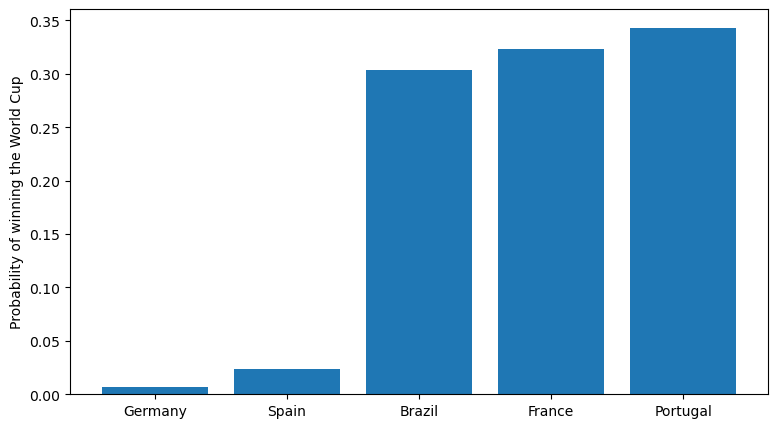

In [62]:
plt.figure(figsize=(9,5))
plt.bar(stats.keys(), stats.values())
plt.ylabel("Probability of winning the World Cup")

In [111]:
predict_cup(dict_groups, dict_knockouts, LR, version="Regression")

             points  proba
Netherlands       9   1.81
Senegal           6   1.34
Qatar             3   0.69
Ecuador           0   0.68
               points  proba
England             9   2.07
Wales               6   1.40
United States       3   1.29
Iran                0   0.15
              points  proba
Argentina          9   1.88
Poland             6   1.27
Mexico             3   1.38
Saudi Arabia       0   0.21
           points  proba
France          9   2.20
Denmark         6   1.27
Australia       1   0.63
Tunisia         1   0.45
            points  proba
Spain            9   2.05
Germany          6   1.75
Japan            3   0.96
Costa Rica       0   0.14
         points  proba
Belgium       9   1.39
Croatia       6   1.42
Morocco       3   0.96
Canada        0   0.68
             points  proba
Brazil            9   1.75
Serbia            6   1.16
Cameroon          1   0.62
Switzerland       1   0.59
                points  proba
Portugal             9   1.86
Uruguay        

{'A1': 'Netherlands',
 'A2': 'Senegal',
 'B1': 'England',
 'B2': 'Wales',
 'C1': 'Argentina',
 'C2': 'Poland',
 'D1': 'France',
 'D2': 'Denmark',
 'E1': 'Spain',
 'E2': 'Germany',
 'F1': 'Belgium',
 'F2': 'Croatia',
 'G1': 'Brazil',
 'G2': 'Serbia',
 'H1': 'Portugal',
 'H2': 'Uruguay',
 'M1': 'Netherlands',
 'M2': 'Argentina',
 'M3': 'Spain',
 'M4': 'Brazil',
 'M5': 'England',
 'M6': 'France',
 'M7': 'Germany',
 'M8': 'Portugal',
 'QF1': 'Argentina',
 'QF2': 'Spain',
 'QF3': 'France',
 'QF4': 'Germany',
 'SF1': 'Spain',
 'SF2': 'France',
 'F': 'France'}